# Wavefrom {Class} Demo

In [1]:
from config.settings import ProjectRoot, LocalDataPath, PlotsPath
from config.plot_config import set_plot_style; set_plot_style()

# import the Waveform class
from models.waveform import Waveform

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import parameters
from config.run_params_1 import (
                            PEAK_THRESH,
                            INGRESS_THRESH,
                            ROI_t_runs,
                            ROI_t_calib
                            )

## Class Description
The *Waveform* class is the first in the reconstruction analysis chain, serving as the precursor the *Event* class. It handles a single waveform readout from one PMT trigger:
- Reading of the csv and conversion to numpy arrays
- Rescaling (i.e. making the signal positive, converting time units to nanometres and voltage to millivolts)
- Baseline caluclation and corrections
- Smoothing
- Peak and ingress detection

In [2]:
# -- Define parameters -- #

# Choose the run number
run = 1

# Plotting window x-cuts
PLOT_CUT = 100

# Signal region of interest:
# Runs up to Run17 are flux measurements and are expected to centre around 0,
# while from Run17 onwards we have calibration measurements. Since the plates
# are now below the triggering calibration plates we expect the signals after 0.
if run < 17:
    # Expected signal around zero
    ROI_t = ROI_t_runs
else:
    # Expected signal after zero
    ROI_t = ROI_t_calib

## Viewing of the Waveform Processing at Each Step

1. Raw waveform loading
2. Rescaling to nanoseconds, +millivolts for easier interpretation
3. Baseline calculation
4. Baseline zeroing
5. Smoothing for more reliable peak detection
6. Detecting the main peak
7. Identifying the ingress of the peak, i.e. the time at which it starts rising.

### Show Waveform Processing Steps

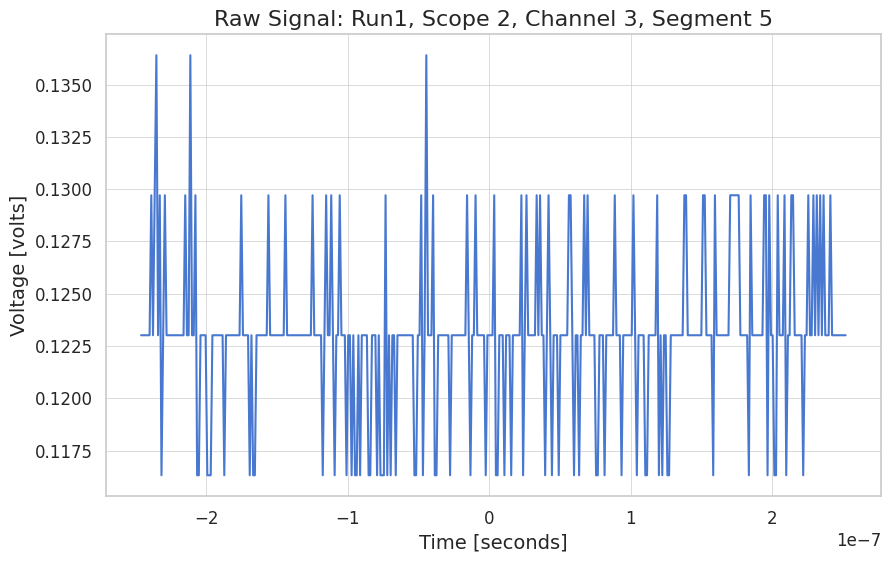

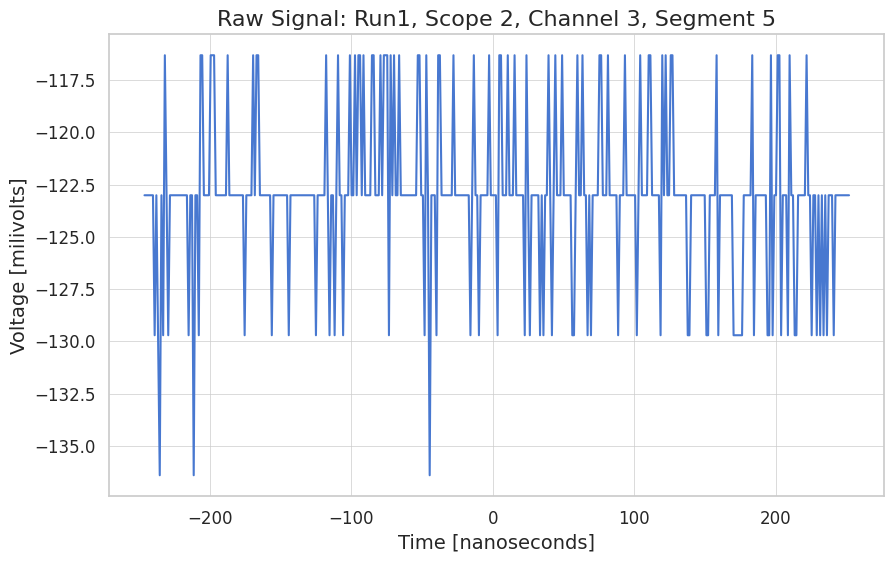

Failed to calculate baseline
attempt to get argmax of an empty sequence


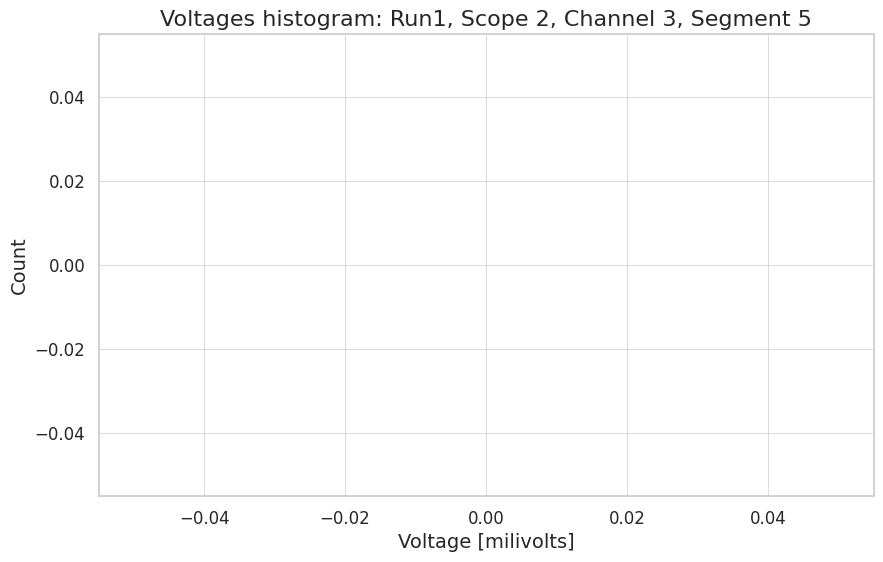

Failed to calculate baseline
attempt to get argmax of an empty sequence


TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

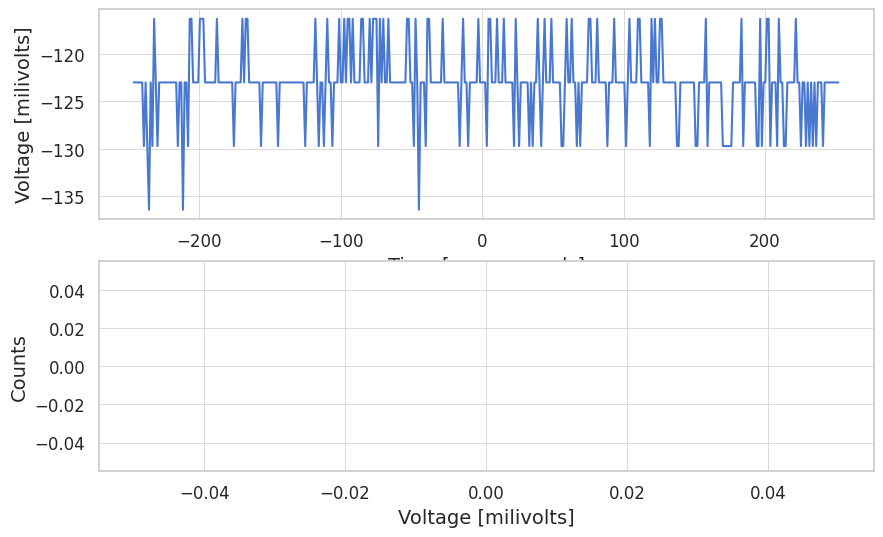

In [5]:
# Pick scope, segment and channel
scope = 2 # [1,2]
seg   = 5
ch    = 3 # [1,8] for Runs [1,16], [1,4] for Runs [17, 30] 

# Raw waveform loading
csvpath = os.path.join(LocalDataPath, f"Run{run}/scope-{scope}-seg{seg}-ch{ch}.csv")
wf = Waveform(csvpath)

# Get the x,y data from class and plot
x, y = wf.get_data(zipped=False)
plt.plot(x, y)
plt.xlabel("Time [seconds]")
plt.ylabel("Voltage [volts]")
plt.title(f"Raw Signal: Run{run}, Scope {scope}, Channel {ch}, Segment {seg}")
plt.show();

xfactor = 1e9 # convert to nanoseconds
yfactor = -1e3 # convert to millivolts and flip signal to be positive

wf.rescale(xfactor=xfactor,yfactor=yfactor)

x, y = wf.get_data(zipped=False)
plt.plot(x, y)
plt.xlabel("Time [nanoseconds]")
plt.ylabel("Voltage [milivolts]")
plt.title(f"Raw Signal: Run{run}, Scope {scope}, Channel {ch}, Segment {seg}")
plt.show();

bin_mids, hist = wf.calculate_baseline(verbose=True)
baseline       = wf.get_baseline()

# Plot the histogram of voltages, the baseline should be clearly visible.
plt.plot(bin_mids, hist)
plt.xlabel("Voltage [milivolts]")
plt.ylabel("Count")
plt.title(f"Voltages histogram: Run{run}, Scope {scope}, Channel {ch}, Segment {seg}")

plt.show();

# ! If you run this block twice the difference would disappear, since the baseline would
# ! have already been removed.

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

# Plot waveform before zeroing
x, y = wf.get_data(zipped=False)
ax1.plot(x, y, label = "Before")
ax1.set_xlabel("Time [nanoseconds]")
ax1.set_ylabel("Voltage [milivolts]")

bin_mids, hist = wf.calculate_baseline(verbose=True)
baseline       = wf.get_baseline()

# Plot the histogram of voltages before zeroing
ax2.plot(bin_mids, hist, label = "Before")
ax2.set_xlabel("Voltage [milivolts]")
ax2.set_ylabel("Counts")


wf.zero_baseline()

# Plot waveform before zeroing
x, y = wf.get_data(zipped=False)
ax1.plot(x, y, label = "After")
ax1.set_xlabel("Time [nanoseconds]")
ax1.set_ylabel("Voltage [milivolts]")
ax1.set_title(f"Run{run}, Scope {scope}, Channel {ch}, Segment {seg}")

bin_mids, hist = wf.calculate_baseline(verbose=True)
baseline       = wf.get_baseline()

# Plot the histogram of voltages before zeroing
ax2.plot(bin_mids, hist, label = "After")
ax2.set_xlabel("Voltage [milivolts]")
ax2.set_ylabel("Counts")
ax2.set_title(f"Voltages histogram: Run{run}, Scope {scope}, Channel {ch}, Segment {seg}")

ax1.legend()
ax2.legend()

fig.tight_layout()

plt.show();

sigma = 2 # Default is = 2
wf.smooth(sigma=sigma)

x, y = wf.get_data(zipped=False)
plt.plot(x, y)
plt.xlabel("Time [nanoseconds]")
plt.ylabel("Voltage [milivolts]")
plt.title(f"{sigma} Sigma Smoothing: Run{run}, Scope {scope}, Channel {ch}, Segment {seg}")
plt.show();

# Convert region of interest to index
x,y = wf.get_data(zipped=False)
a = np.argmin(np.abs(x - ROI_t[0]))
b = np.argmin(np.abs(x - ROI_t[1]))

ROI_idx = [a,b]

# Run peak detection method
wf.detect_main_peak(ROI_idx, 125)

try:
    peak_idx, peak_val            = wf.get_main_peak()
    plt.scatter(x[peak_idx], y[peak_idx], color = 'black', zorder=3, label = "Peak Bin")
except:
    print("No peak detected")

plt.axvspan(ROI_t[0], ROI_t[1], color = 'lawngreen', alpha = 0.2, label = 'ROI')

plt.xlabel("Time [nanoseconds]")
plt.ylabel("Voltage [milivolts]")

plt.xlim(x[PLOT_CUT], x[-PLOT_CUT])
plt.legend()
plt.plot(x,y);

# Convert region of interest to index
x,y = wf.get_data(zipped=False)
a = np.argmin(np.abs(x - ROI_t[0]))
b = np.argmin(np.abs(x - ROI_t[1]))

ROI_idx = [a,b]

wf.identify_ingress(25, ROI_idx)

try:
    ingress_time_val = wf.ingress_val
    plt.scatter(ingress_time_val, INGRESS_THRESH , color = 'black', 
                zorder=3, label = f"Ingress Bin: {np.round(ingress_time_val,2)} [ns].")
except:
    print("Failed to detect ingress time.")

plt.axvspan(ROI_t[0], ROI_t[1], color = 'lawngreen', alpha = 0.2, label = 'ROI')

plt.xlabel("Time [nanoseconds]")
plt.ylabel("Voltage [milivolts]")

plt.xlim(x[PLOT_CUT], x[-PLOT_CUT])
plt.legend()
plt.plot(x,y)
plt.show()